In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_mae
import scipy.io as sio
import cv2
import open3d as o3d

In [2]:
def show_image(image, title=''):
    image = np.array(image)
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    # print(checkpoint['model'])
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    # msg = model.load_state_dict(checkpoint, strict=False)
    print(msg)
    return model

def ero(img,kernel_size=1):
    img = np.array(img)
    kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(kernel_size,kernel_size))
    img2 = cv2.erode(img,kernel,iterations=1)
    return img2

def run_one_image(img, model, imggt):
    x = torch.tensor(img)
    gt = torch.tensor(imggt)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    gt = gt.unsqueeze(dim=0).unsqueeze(dim=-1).repeat(1,1,1,4)
    gt = torch.einsum('nhwc->nchw', gt)

    # run MAE
    model = model.float()
    loss, y, mask = model(x.float(), mask_ratio=0.5)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *4)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    gt = torch.einsum('nchw->nhwc', gt)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    diff = abs(gt-im_paste) *60000/4000
    diff_ = torch.where(gt == 0 , torch.zeros(gt.shape).type(diff.dtype), diff)
    loss = diff_ ** 2 
    loss = loss[0,:,:,3]
    loss = loss.sum()  # [N, L], mean loss per patch

    loss = loss  / torch.nonzero(gt[0,:,:,3]).sum()
    loss = torch.sqrt(loss)
    diff_raw = abs(gt-x)

    me = diff_[0,:,:,3].sum() / torch.nonzero(gt[0,:,:,3]).sum()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(2, 4, 1)
    show_image(x[0,:,:,3], "raw")
    print(f'rawmax{torch.max(x[0,:,:,3])}---rawmin{torch.min(x[0,:,:,3])}')

    plt.subplot(2, 4, 2)
    show_image(im_masked[0,:,:,3], "raw_masked")

    plt.subplot(2, 4, 3)
    show_image(y[0,:,:,3], "rec")
    print(f'reconmax{torch.max(y[0,:,:,3])}---reconmin{torch.min(y[0,:,:,3])}')

    plt.subplot(2, 4, 4)
    show_image(im_paste[0,:,:,3], "rec + raw")
    print(f'recon&rawmax{torch.max(im_paste[0,:,:,3])}---recon&rawmin{torch.min(im_paste[0,:,:,3])}')

    plt.subplot(2, 4, 5)
    show_image(diff_[0,:,:,3], "diff_rec")
    print(f'diffrecmax{torch.max(diff[0,:,:,3])}---diffrecmin{torch.min(diff[0,:,:,3])}')\
    
    plt.subplot(2, 4, 6)
    show_image(diff_raw[0,:,:,3], "diff_raw")
    print(f'diffrawmax{torch.max(diff_raw[0,:,:,3])}---diffrawmin{torch.min(diff_raw[0,:,:,3])}')

    plt.subplot(2, 4, 7)
    show_image(gt[0,:,:,3], "original")
    print(f'gtmax{torch.max(gt[0,:,:,3])}---gtmin{torch.min(gt[0,:,:,3])}')

    

    print(f'rmse:{loss}')
    print(f'me:{me}')
    from util import pytorch_ssim
    ssim_helper=pytorch_ssim.SSIM(11)
    ss = ssim_helper(im_paste[0,:,:,3].unsqueeze(0).unsqueeze(0), gt[0,:,:,3].unsqueeze(0).unsqueeze(0)).data.numpy()
    print(f'ssim:{ss}')
    return x[0,:,:,3], im_masked[0,:,:,3], im_paste[0,:,:,3],gt[0,:,:,3]

    # plt.show()

def rgbd2pcd(color_p,depth_p,name):
    color = o3d.io.read_image(color_p)
    depth = o3d.io.read_image(depth_p)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, depth_scale=10000.0, depth_trunc=6.0, convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # print("Radius oulier removal")
    # pcd, ind = pcd.remove_radius_outlier(nb_points=16, radius=0.05)
    o3d.io.write_point_cloud(name,pcd)


In [3]:
chkpt_dir = "/mnt/yangzhou/random_224_75_4_0/checkpoint-199.pth"
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


/home/yangzhou/miniconda3/envs/tg/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
/home/yangzhou/miniconda3/envs/tg/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
/home/yangzhou/miniconda3/envs/tg/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


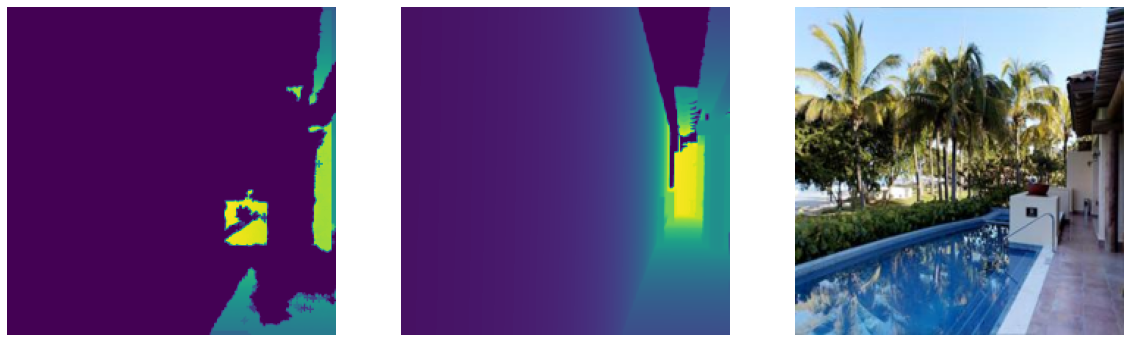

In [4]:
img = Image.open("/mnt/yangzhou/dataset/matterport/test/raw_depth/pa4otMbVnkk/resize_b13bc7ca024046de92640c76f26a9f07_d1_3.png")
imggt = Image.open("/mnt/yangzhou/dataset/matterport/test/GT_depth/pa4otMbVnkk/resize_b13bc7ca024046de92640c76f26a9f07_d1_3_mesh_depth.png") #电视客厅
img_np = np.load("/mnt/yangzhou/dataset/matterport/npy/test/pa4otMbVnkk/resize_b13bc7ca024046de92640c76f26a9f07_i1_3.npy")
# img = Image.open("/mnt/yangzhou/dataset/matterport/test/raw_depth/fzynW3qQPVF/resize_23f90479f2cf4c60bc78cb3252fe64e8_d1_1.png")           
# imggt = Image.open("/mnt/yangzhou/dataset/matterport/test/GT_depth/fzynW3qQPVF/resize_23f90479f2cf4c60bc78cb3252fe64e8_d1_1_mesh_depth.png")#大厨房
# img = Image.open("/mnt/yangzhou/dataset/matterport/test/raw_depth/fzynW3qQPVF/resize_23f90479f2cf4c60bc78cb3252fe64e8_d1_4.png")           
# imggt = Image.open("/mnt/yangzhou/dataset/matterport/test/GT_depth/fzynW3qQPVF/resize_23f90479f2cf4c60bc78cb3252fe64e8_d1_4_mesh_depth.png")#大客厅
# img = Image.open("/mnt/yangzhou/dataset/matterport/test/raw_depth/pa4otMbVnkk/resize_f6189fb4dada4dfb869dd8031eeb95d4_d1_5.png")
# imggt = Image.open("/mnt/yangzhou/dataset/matterport/test/GT_depth/pa4otMbVnkk/resize_f6189fb4dada4dfb869dd8031eeb95d4_d1_5_mesh_depth.png")
# img = Image.open("/mnt/yangzhou/dataset/matterport/test/raw_depth/pa4otMbVnkk/resize_0e3de34758ff49cbb528b6019a8912db_d1_4.png")
# imggt = Image.open("/mnt/yangzhou/dataset/matterport/test/GT_depth/pa4otMbVnkk/resize_0e3de34758ff49cbb528b6019a8912db_d1_4_mesh_depth.png") 
# img_np = np.load("/mnt/yangzhou/dataset/matterport/npy/test/pa4otMbVnkk/resize_0e3de34758ff49cbb528b6019a8912db_i1_4.npy")

# img = Image.open("/mnt/yangzhou/dataset/matterport/test/raw_depth/q9vSo1VnCiC/resize_8711ca7a77f34e21b14160642b831288_d1_2.png")
# imggt = Image.open("/mnt/yangzhou/dataset/matterport/test/GT_depth/q9vSo1VnCiC/resize_8711ca7a77f34e21b14160642b831288_d1_2_mesh_depth.png") 
# img_np = np.load("/mnt/yangzhou/dataset/matterport/npy/test/q9vSo1VnCiC/resize_8711ca7a77f34e21b14160642b831288_i1_2.npy")


import copy
img_temp = copy.deepcopy(img_np)
img = img_np[:,:,3]
cv2.imwrite('/home/yangzhou/mae_color/test.png', img*60000)

img = Image.fromarray(img)

img_pil = Image.fromarray(np.uint8((img_np[:,:,:-1])*255))
cv2.imwrite('/home/yangzhou/mae_color/test.jpg', np.uint8((img_np[:,:,:-1])*255))
rgbd2pcd('/home/yangzhou/mae_color/test.jpg','/home/yangzhou/mae_color/test.png','/home/yangzhou/mae_color/test.ply')

img_pil = img_pil.resize((224,224),Image.BICUBIC)
img_npy = np.array(img_pil)
img = img.resize((224,224),Image.NEAREST)
img = ero(img,5)
img_np = np.concatenate((img_npy/255,np.expand_dims(img,axis=-1)),axis=-1)


imggt = imggt.resize((224,224),Image.NEAREST)
# img = np.array(img) / 10000
imggt = np.array(imggt) / 60000

plt.rcParams['figure.figsize'] = [20, 20]
plt.subplot(1, 3, 1)
show_image(img)
plt.subplot(1, 3, 2)
show_image(imggt)
plt.subplot(1, 3, 3)
show_image(img_npy)

MAE with pixel reconstruction:
rawmax0.5255500078201294---rawmin0.0
reconmax0.46718165278434753---reconmin-0.01993563398718834
recon&rawmax0.5255500078201294---recon&rawmin-0.01993563398718834
diffrecmax13.72725---diffrecmin0.0
diffrawmax0.9210166666666667---diffrawmin0.0
gtmax0.9210166666666667---gtmin0.0
rmse:0.23088457851514801
me:0.010729066374748101
ssim:0.30843085796590897


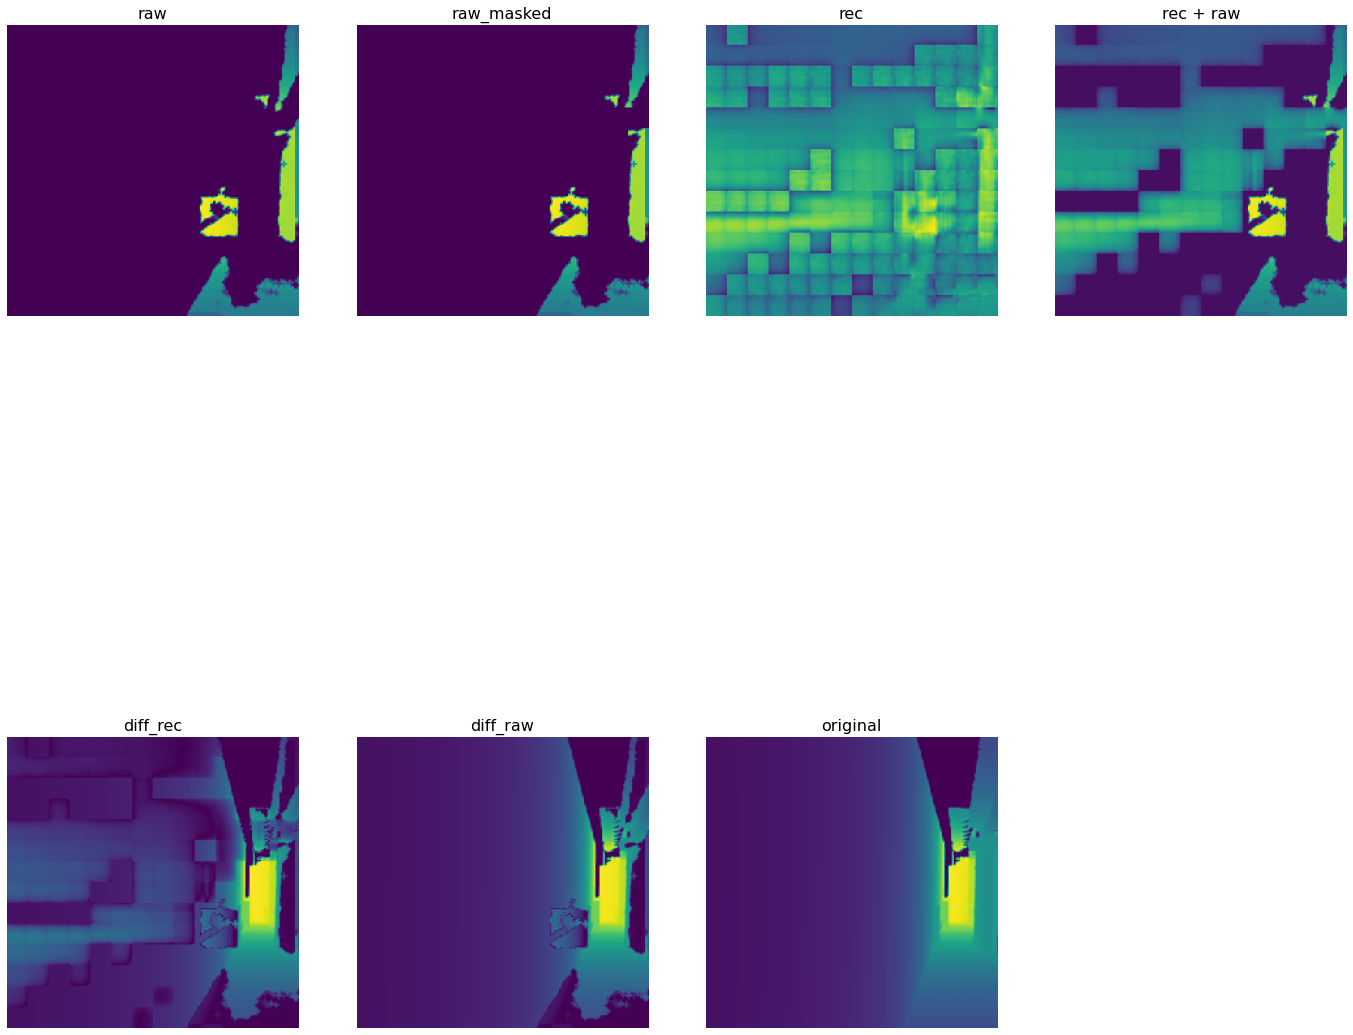

In [5]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(3407)
print('MAE with pixel reconstruction:')
raw, masked, pred,gt = run_one_image(img_np, model_mae,imggt)

In [6]:


save_path = '/home/yangzhou/painting.mat' #256x320
def resize_tensor2array(ten):
    arr = ten.numpy()
    arr = cv2.resize(arr, (320,256), interpolation = cv2.INTER_AREA)
    out = np.array(arr)*60000
    out = np.uint16(out)
    out = np.where(out > 0, out, 0)
    return out



raw_p = '/home/yangzhou/mae_color/raw.png'
pred_p='/home/yangzhou/mae_color/pred.png'
gt_p = '/home/yangzhou/mae_color/gt.png'
rgb_p = '/home/yangzhou/mae_color/rgb.jpg'
raw = resize_tensor2array(raw)
pred = resize_tensor2array(pred)
masked = resize_tensor2array(masked)
gt = resize_tensor2array(gt)


rgb = np.uint8((img_temp[:,:,:-1])*255)


rgb = Image.fromarray(rgb)
cv2.imwrite(raw_p, raw)
cv2.imwrite(pred_p, pred)
cv2.imwrite(gt_p, gt)
rgb.save(rgb_p)

rgbd2pcd(rgb_p,raw_p,raw_p[:-4]+'.ply')
rgbd2pcd(rgb_p,pred_p,pred_p[:-4]+'.ply')
rgbd2pcd(rgb_p,gt_p,gt_p[:-4]+'.ply')

# sio.savemat(save_path, {'raw': raw,'pred':pred,'masked':masked,'gt':gt})




/home/yangzhou/miniconda3/envs/tg/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  """


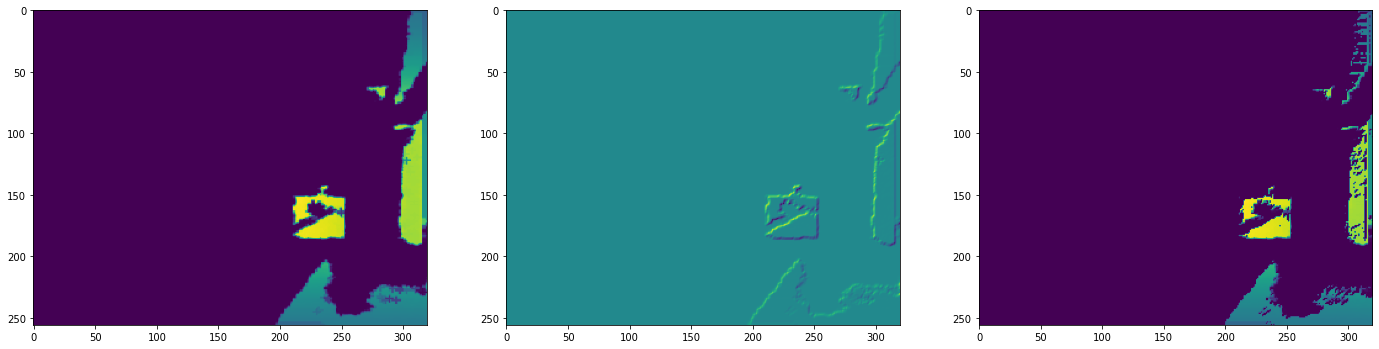

In [7]:
raw_gra_ = np.gradient(raw)
raw_gra = raw_gra_[0]+raw_gra_[1]
# print(np.max(raw_gra))
# hist,bins=np.histogram(raw_gra,bins=[0,200,400,600,800,1000,1200,1400,1600,1800,2000,4000,5000,50000,100000])
# plt.hist(hist,bins ) 
# plt.title("histogram") 
# plt.show()
raw2 = np.where(raw_gra>100,0,raw)

plt.subplot(1, 3, 1)
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(raw)
plt.subplot(1, 3, 2)
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(raw_gra)
plt.subplot(1, 3, 3)
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(raw2)

cv2.imwrite(raw_p, raw2)
rgbd2pcd(rgb_p,raw_p,raw_p[:-4]+'2.ply')